In [4]:
import pickle as pkl
import matplotlib.pyplot as plt  
import numpy as np

%matplotlib inline

## Pre-processing and Loading
Images have been cropped to focus only on faces.
Resized to 64×64×3 for uniformity.
A smaller subset of the dataset is used.

## Implement get_dataloader
The function should convert images into square tensors of size image_size × image_size.
Return a DataLoader that shuffles and batches the images for training.

## Using ImageFolder
ImageFolder helps load images from a directory.
It applies data transformations, such as resizing and converting to tensors.
The DataLoader will batch and shuffle images to improve training stability.

In [5]:
import torch
from torchvision import datasets
from torchvision import transforms

In [6]:
from torch.utils.data import Dataset, DataLoader
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small'):
    
    # Re-size images to 32 x 32
    transform = transforms.Compose([transforms.Resize(image_size), 
                                    transforms.ToTensor()])
    
    # Define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(data_dir, transform)

    # Create and return DataLoaders
    data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    return data_loader

## Create a DataLoader

#### Task: Define a celeba_train_loader with suitable hyperparameters.

Choose a reasonable batch_size.
Set image_size to 32 for faster training while maintaining clear facial features.
Create the DataLoader and use it to visualize images.

In [7]:
# Hyperparameters for the function
batch_size = 32
img_size = 32

# Get dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

## View Some Images
You should see square images of roughly centered faces.

Note: Convert the Tensor images to NumPy and transpose the dimensions for correct display. The suggested imshow code below may need adjustments.

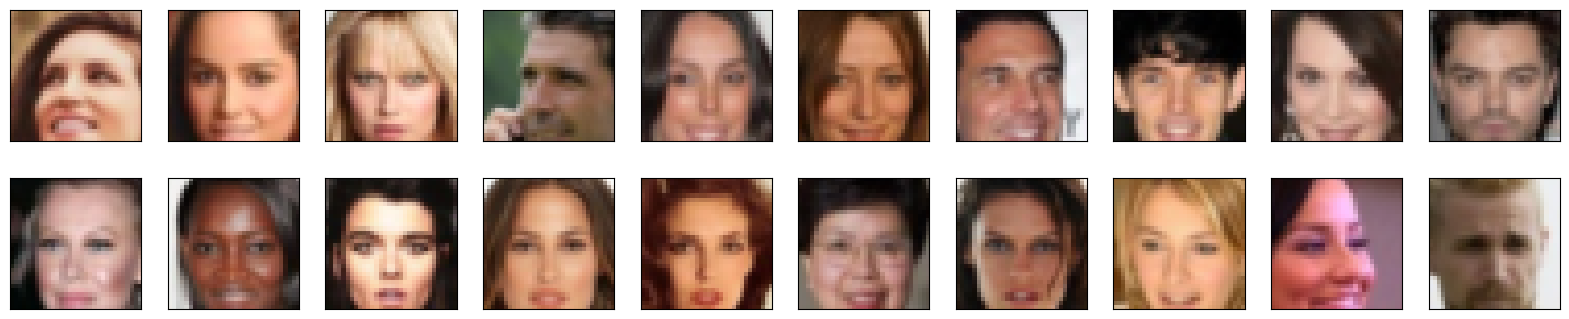

In [8]:
# Display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Get a single batch of training images
for images, _ in celeba_train_loader:  # Iterating directly over DataLoader
    break  # Stop after the first batch

# Sample image plotting
fig = plt.figure(figsize=(20, 4))
plot_size = 20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size // 2, idx + 1, xticks=[], yticks=[])
    imshow(images[idx])

## Pre-process and Scale Image Data
Your training images currently have pixel values in the 0 to 1 range. However, since the generator uses a tanh activation function, its output will be in the -1 to 1 range.

In [9]:
def scale(x, feature_range=(-1, 1)):
    min, max = feature_range
    x = x * (max - min) + min
    
    return x

In [10]:
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8902)
Max:  tensor(0.9294)


## Define the Model
A GAN consists of two competing networks: a discriminator and a generator.

## Discriminator
Your first task is to define the discriminator. This is a convolutional classifier similar to previous models but without max-pooling layers. Since the dataset is complex, a deep network with normalization is recommended. You may also create helper functions if needed.

## To implement a Discriminator Class,
Input: 32×32×3 tensor images
Output: A single value indicating whether the image is real or fake

In [11]:
import torch.nn as nn
import torch.nn.functional as F

In [12]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                    kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
  
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)  

In [13]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        super(Discriminator, self).__init__()

        # progressively reduces the image size from 32 x 32 → 16 x 16 → 8 x 8 → 4 x 4 using convolutional layers.
        # It also increases the number of feature maps (channels) at each step.

        # Init
        self.conv_dim = conv_dim
        # 32 x 32 Input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # No batch norm for the first layer
        # 16 x 16 Output
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8 x 8 Output
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4 x 4 Output
        
        # Fully-connected final layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):

         # All hidden layers + Leaky reLU activation layer
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        # Flattening
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # Final output layer
        out = self.fc(out)        
        return out

## Generator
The generator takes an input vector of length z_size and transforms it into a 32×32×3 image using mostly transpose convolutional layers with normalization.

## To build the Generator Class
Input: Vector of size z_size
Output: Generated image of shape 32×32×3

In [14]:
# Help deconvolution (transposed convulation) layer
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):

    # Create a sequence of transpose + optional batch normalisation layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # Append transpose convolutional layer
    layers.append(transpose_conv_layer)

    # Append batchnorm layer
    if batch_norm:   
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [15]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        super(Generator, self).__init__()

        # Init
        self.conv_dim = conv_dim
        
        # Fully-connected first layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # Transpose convolution layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):

        # Feedforward behavior is defined
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # Hidden layers (transpose convolution + reLU)
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # Final layer and then tanh activation layer
        out = self.t_conv3(out)
        out = F.tanh(out)
        
        return out


## Initialize the Weights
To help the models converge, you'll initialize the weights of the convolutional and linear layers. According to the DCGAN paper, the weights should be:

Zero-centered Normal distribution with standard deviation 0.02

## To implement the Weight Initialization Function,
Target Layers: Only convolutional and linear layers.
Initialization: Use a normal distribution with mean 0 and standard deviation 0.02.
Bias Terms: Optionally set to 0, or leave them unchanged.

In [16]:
from torch.nn import init

def weights_init_normal(m):
    classname = m.__class__.__name__ # `Conv`, `BatchNorm2d`, `Linear`, etc.
    
    # Weights init
    init_type='normal'
    init_gain=0.02

    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:  # For BatchNorm layers, the weight is not a matrix but a scalar value with normalised distribution
        init.normal_(m.weight.data, 1.0, init_gain)
        init.constant_(m.bias.data, 0.0)

## Build Complete Network
Define the models' hyperparameters and create instances of the discriminator and generator, passing the correct input arguments.

In [17]:
def build_network(d_conv_dim, g_conv_dim, z_size):

    # Define discriminator
    D = Discriminator(d_conv_dim)

    # Define generator
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # Init weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

In [18]:
# Hyperparameters for the model
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

## Training on GPU
Set a boolean variable train_on_gpu to check if training can be done on GPU. 

Ensure that:

Models, Model inputs, Loss function arguments are moved to the GPU when necessary.

In [19]:
import torch

# Check if a GPU is available
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('GPU not available. Consider using a GPU for faster training.')
else:
    print('Using GPU for training!')

GPU not available. Consider using a GPU for faster training.


# Discriminator and Generator Losses

## Discriminator Loss

The total loss for the discriminator is the sum of the losses for real and fake images.
The discriminator aims to output 1 for real images and 0 for fake images, so the loss should be set up to reflect that.

## Generator Loss

The generator's loss is similar but with flipped labels, as the generator tries to make the discriminator believe its generated images are real.

To implement Real and Fake Loss Functions,

You can use either cross-entropy or least squares error for the real_loss and fake_loss functions.

In [20]:
def real_loss(D_out, smooth=True):

    batch_size = D_out.size(0)
    
    # Label smoothing
    if smooth:
        # Smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # Move labels to GPU it is available     
    if train_on_gpu:
        labels = labels.cuda()

    # Binary cross-entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()

    # Calculate the loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):

    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # Fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    
    # Calculate the loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

Define Optimizers for Discriminator (D) and Generator (G)

Set up optimizers for both the Discriminator and Generator with suitable hyperparameters.

In [21]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G with the following parameters
lr = 0.001
beta1=0.1
beta2=0.999 # Default value

# Create optimizers
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

## Training
Training will alternate between the discriminator and the generator. You'll use real_loss and fake_loss to calculate the discriminator losses.

1) Train the discriminator on both real and fake images.
2) Train the generator to trick the discriminator with an opposing loss function.

### Note
If you had moved your models to GPU, you will also have to move any model inputs to GPU.

In [22]:
def train(D, G, n_epochs, print_every=50):

    # Move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # Keep track of loss and generated 'fake' sample images
    samples = []
    losses = []

    # Sample fixed images which allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    
    # Move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # Epoch training loop
    for epoch in range(n_epochs):

        # Batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # Train the discriminator on real and fake images
            d_optimizer.zero_grad()

            # Train with real images and compute the discriminator losses on those 
            if train_on_gpu:
                real_images = real_images.cuda()
        
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
        
            # Train with fake images
        
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()

            # Move x to GPU if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
        
            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
        
            # Add up loss and perform backpropogation
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # Train the generator with an adversarial loss
            g_optimizer.zero_grad()
        
            # Train with fake images and flipped labels
        
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
        
            # Compute the discriminator losses on fake images using flipped labels
            D_fake = D(fake_images)

            # Use real loss to flip labels
            g_loss = real_loss(D_fake) 
        
            # Backpropogation
            g_loss.backward()
            g_optimizer.step()
            
            # Print some loss stats
            if batch_i % print_every == 0:
                # Discriminator loss and Generator loss
                losses.append((d_loss.item(), g_loss.item()))

                # Print loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        # Generate and save fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # Return loss
    return losses

We can now train the DGGAN !!

In [23]:
# Epoch count 
n_epochs = 50

# Train !! 
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.4531 | g_loss: 1.7930
Epoch [    1/   50] | d_loss: 1.0028 | g_loss: 1.7725
Epoch [    1/   50] | d_loss: 1.0874 | g_loss: 1.0599
Epoch [    1/   50] | d_loss: 1.4430 | g_loss: 1.1140
Epoch [    1/   50] | d_loss: 1.2749 | g_loss: 1.8633
Epoch [    1/   50] | d_loss: 1.2430 | g_loss: 1.4931
Epoch [    1/   50] | d_loss: 1.4614 | g_loss: 0.8953
Epoch [    1/   50] | d_loss: 1.6741 | g_loss: 0.5690
Epoch [    1/   50] | d_loss: 1.2134 | g_loss: 0.8588
Epoch [    1/   50] | d_loss: 1.2330 | g_loss: 0.8849
Epoch [    1/   50] | d_loss: 1.3815 | g_loss: 0.9034
Epoch [    1/   50] | d_loss: 1.3121 | g_loss: 0.9969
Epoch [    1/   50] | d_loss: 1.2293 | g_loss: 0.8253
Epoch [    1/   50] | d_loss: 1.3711 | g_loss: 1.1124
Epoch [    1/   50] | d_loss: 1.2418 | g_loss: 1.1917
Epoch [    1/   50] | d_loss: 1.3197 | g_loss: 0.9222
Epoch [    2/   50] | d_loss: 1.3600 | g_loss: 1.2138
Epoch [    2/   50] | d_loss: 1.2820 | g_loss: 0.8297
Epoch [    2/   50] | d_loss

# Training Loss

Plot the training losses for both the generator and discriminator, recorded after each epoch.

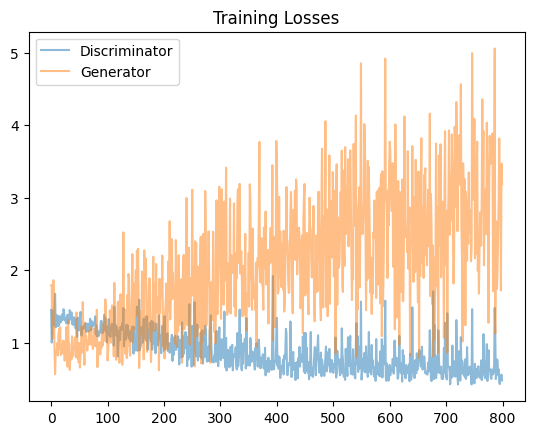

In [24]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator Samples from Training

View images generated by the model, and evaluate the strengths and weaknesses of the trained generator.

In [25]:
# Function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [26]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

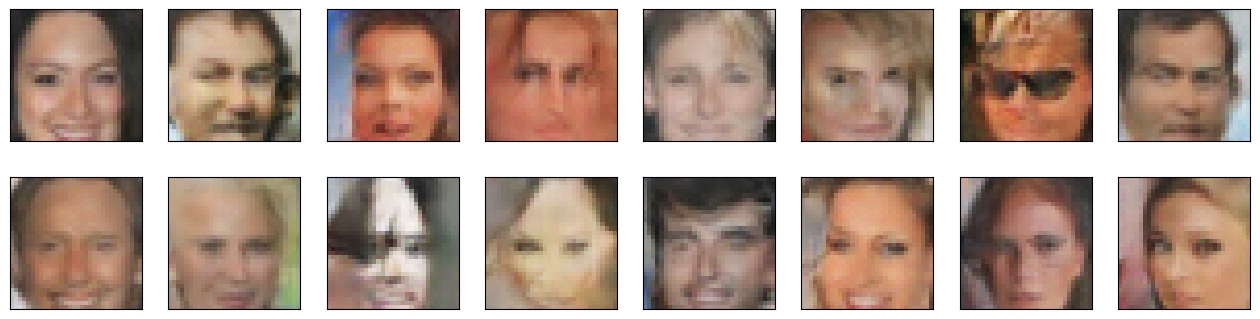

In [27]:
_ = view_samples(-1, samples)